In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate, GridSearchCV

In [45]:
df = pd.read_csv('demo_sales.csv')
df.tail()

,Date,Units,Sales
1088,27/12/2022,7114,22551.38
1089,28/12/2022,7759,24596.03
1090,29/12/2022,6457,20468.69
1091,30/12/2022,7284,23090.28
1092,31/12/2022,0,0.00


### Create features

In [ ]:
target_map = data['sales'].to_dict()

data['lag1'] = (data['date'] - pd.Timedelta('364 days')).map(target_map)
data['lag2'] = (data['date'] - pd.Timedelta('728 days')).map(target_map)
data['lag3'] = (data['date'] - pd.Timedelta('1092 days')).map(target_map)

In [49]:
#df['Date'] = df['Date'].str.replace('/', '-').head()
df['Date'] = pd.to_datetime(df['Date'], 
#               errors='ignore', 
                format='%d/%m/%Y',
                dayfirst=True)
df.tail()

,Date,Units,Sales
1088,2022-12-27,7114,22551.38
1089,2022-12-28,7759,24596.03
1090,2022-12-29,6457,20468.69
1091,2022-12-30,7284,23090.28
1092,2022-12-31,0,0.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093 entries, 0 to 1092
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1093 non-null   datetime64[ns]
 1   Units   1093 non-null   int64         
 2   Sales   1093 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 25.7 KB


In [51]:
X = df.drop(['Units', 'Sales'], axis=1)
y = df['Units']
X

,Date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
1088,2022-12-27
1089,2022-12-28
1090,2022-12-29
1091,2022-12-30


### Preprocess

In [ ]:

num_features = X

preprocessor = ColumnTransformer(
    [
        ('StandardScaler', StandardScaler(), num_features),
    ]
) 

In [ ]:
X = preprocessor.fit_transform()

### Evaluate models

In [ ]:
def evaluate_model(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

NameError: name 'LinearRegression' is not defined

In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'XGBRegressor': XGBRegressor()
}

model_list = []
r2_list = []
rmse_list = []
results = []
param_grid = {'': [0, 1]}


for model_name, model in models.items():
    time_series_split = TimeSeriesSplit(n_splits=6)
    cv_scores = cross_validate(model, X, y, cv=time_series_split)
    #cv_results = cross_val_score(model, X_train, y_train, cv=cv)
    
    # Fine tune hyperparams
    gs = GridSearchCV(model, cv=time_series_split, param_grid=param_grid)
    gs.fit(X, y)
    results.append(cv_scores['test_score'].mean())

    #train_rmse, train_r2 = evaluate_model() # ???
    #y_pred_test = model.predict(X_test)
    #test_rmse, test_r2 = evaluate_model(y_test, y_pred_test)
    print(model_name)
    print('Model performance for Training set')
    print(f'- RMSE: {train_rmse}')
    print(f'- R2: {train_r2}')
    print('-----------------------------')
    print('Model performance for Test set')
    print(f'- RMSE: {test_rmse}')
    print(f'- R2: {test_r2}')

plt.boxplot(results, labels=models.keys())
plt.show()

In [ ]:
# Need to encode date somehow to pass to X

# Create lag features

In [56]:
import numpy as np
import xgboost as xgb
#para = param[LinearRegression()]
# or this, not sure 
param_grid = {'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'n_estimators': [100,200,400]
}
X1 = y.shift(1)
time_series_split = TimeSeriesSplit(test_size=90)


#model = LinearRegression()
model = XGBRegressor(random_state=1)
#xgb.DMatrix()
# Perform randomized grid search on train data and find best params
gs = GridSearchCV(model, param_grid, cv=time_series_split, scoring='neg_root_mean_squared_error')
gs.fit(X1, y)

print("Best CV score: ", np.abs(gs.best_score_))

#model.set_params(**gs.best_params_)
#gs.best_score_

#cv_scores = cross_validate(model, X, y, cv=time_series_split)
#print("CV score: ", cv_scores['test_score'].mean())

Best CV score:  2251.838330078125


In [58]:
gs.best_params_

{'learning_rate': 0.01, 'n_estimators': 100}

In [ ]:
# Fit best parameters to model and train it on full data to make real predictions
final_model = XGBRegressor(**gs.best_params)
final_model.fit(X1)
predictions = final_model.predict(*unseen dates*)

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [ ]:
def check_stationarity(data):
    result = adfuller(data, autolag='AIC')
    p_value = result[1]
    print(f'p-value is {round(p_value, 3)}' + ' => ' + 'Stationary' if p_value < 0.05 else 'Non-stationary')

check_stationarity(y)

p-value is 0.0 => Stationary


Time-series is stationary, therefore we **can** apply SARIMA

In [76]:
X_train = df[['Date','Units']][:-90].set_index('Date')
X_test = df[['Date','Units']][-90:].set_index('Date')
y_train = y[:-90]
y_test = y[-90:]
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12
model = SARIMAX(X_train, order=(p,d,q), seasonal_order=(P,D,Q,s))
trained_model = model.fit()

forecast = trained_model.get_forecast(steps=90)


c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Vector\Documents\GitHub\Demand-Forecasting-Web-app\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is a

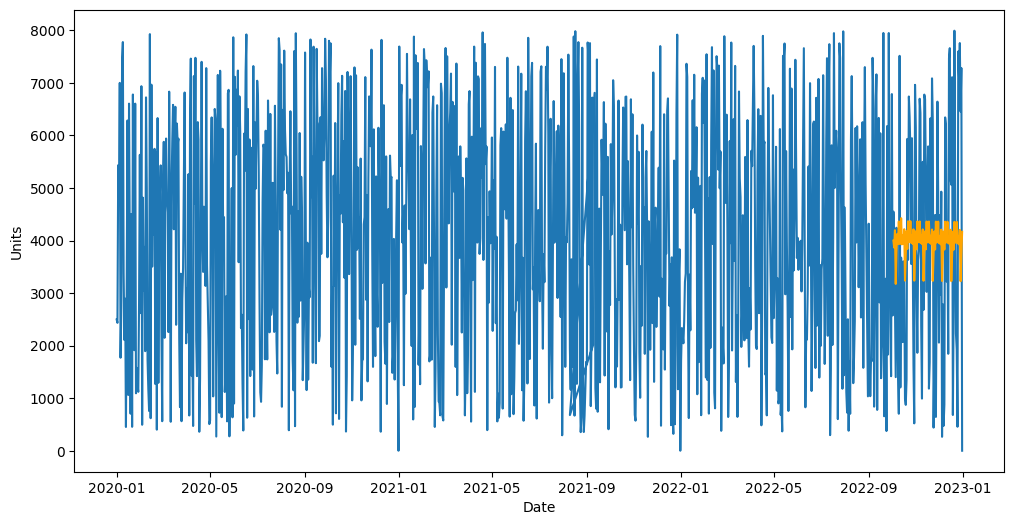

In [82]:
import matplotlib.pyplot as plt
all_data = df[['Date','Units']].set_index('Date')
plt.figure(figsize=(12,6))
plt.plot(all_data, label='Observed')
plt.plot(X_test.index, forecast.predicted_mean, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Units')
plt.show()

The mofrl is quite bad, need to fine-tune it

In [ ]:
param_grid = {'p': [0,1],
              'd': [0,1],
              'q': [0,1],
              'P': [0,1],
              'D': [0,1],
              'Q': [0,1],
              's': [12]
              }

time_series_split = TimeSeriesSplit(test_size=90)
# idk how to perform gridsearch on sarima model, the model wants data as mandatory input and it contradicts the GS func params
model = SARIMAX(time_series_split)
gs = GridSearchCV(model, param_grid, cv=time_series_split, scoring='neg_root_mean_squared_error')
gs.fit(X_train.index, X_train)

TypeError: object of type 'TimeSeriesSplit' has no len()

In [ ]:
final_model = SARIMAX(**gs.best_params)
final_model.fit()
forecast1 = final_model.get_forecast(steps=90)

1003    3998.449101
1004    3866.399832
1005    4196.835878
1006    3174.777798
1007    3791.256789
           ...     
1088    3925.895877
1089    4203.734368
1090    3226.262258
1091    3719.454801
1092    4166.152706
Name: predicted_mean, Length: 90, dtype: float64